In [59]:
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import imageio
from PIL import Image
from scipy.ndimage import binary_dilation
from gelgenie.segmentation.helper_functions.general_functions import create_dir_if_empty

In [12]:
target_images = ['CB 2022-06-03_17h22m08s', 'Picture1', 'Picture5', '20200904 G15 Au Conc pH 4 25 mM NaCl', 'CB 2023-10-18_18h26m27s', '20190416 Gel1 Gold A15']
input_extensions = ['.tif', '.png', '.jpg', '.tif', '.tif', '.tif']

models = ['unet_dec_21', 'unet_dec_21_finetune', 'watershed', 'multiotsu']

percentile_norm_results_folder = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_evaluation/external_test_set_eval/external_eval_percentile_norm'
standard_norm_results_folder = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_evaluation/external_test_set_eval/external_eval_standard'

input_images = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/data/gels_for_paper_revisions/assembled_set/images'
gt_masks = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/data/gels_for_paper_revisions/assembled_set/masks'

In [69]:

image_packages = defaultdict(dict)
for t_im, t_ext in zip(target_images, input_extensions):
    image_packages[t_im]['GT'] = np.array(Image.open(join(gt_masks, f'{t_im}.tif')).convert('L'))
    image_packages[t_im]['GT'][image_packages[t_im]['GT'] < 255] = 0
    image_packages[t_im]['GT'] = 255 - image_packages[t_im]['GT']

    image_packages[t_im]['input'] = imageio.v2.imread(join(input_images, t_im + t_ext))

    for model in models:
        image_packages[t_im][f'percentile-{model}'] = np.array(Image.open(join(percentile_norm_results_folder, model, f'{t_im}_map_only.png')).convert('L'))
        image_packages[t_im][f'standard-{model}'] = np.array(Image.open(join(standard_norm_results_folder, model, f'{t_im}_map_only.png')).convert('L'))
        image_packages[t_im][f'percentile-{model}'][image_packages[t_im][f'percentile-{model}'] > 0] = 255
        image_packages[t_im][f'standard-{model}'][image_packages[t_im][f'standard-{model}'] > 0] = 255



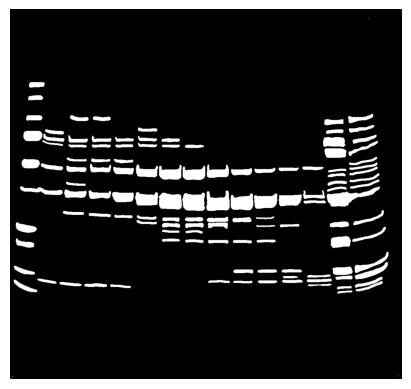

In [70]:
plt.imshow(image_packages['Picture5']['GT'], cmap='gray')
plt.axis('off')
pass

In [73]:
output_folder = '/Users/matt/Desktop/external_test_set_segmentation_maps'
create_dir_if_empty(output_folder)
for im_key, pack in image_packages.items():
    pack_folder = join(output_folder, im_key)
    create_dir_if_empty(pack_folder)

    # save input image (inverted)
    max_value = 255 if pack['input'].dtype == np.uint8 else 65535
    inverted_array = max_value - pack['input']
    inverted_img = Image.fromarray(inverted_array)
    inverted_img.save(join(pack_folder, im_key + '.tif'))

    # save all maps
    for key, mask in pack.items():
        if key == 'input':
            continue

        rgba_image = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)

        outline = binary_dilation(mask == 255, iterations=3) & ~(mask == 255)

        rgba_image[outline] =  (0, 255, 255, int(0.8 * 255))
        rgba_image[mask == 255] = [0, 255, 255, int(0.4 * 255)]
        output_image = Image.fromarray(rgba_image, mode='RGBA')
        output_image.save(join(pack_folder, key + '_mask.png'))